In [1]:
import os.path
import warnings
import tensorflow as tf
import glob
import project_tests as ptests
import helper

In [2]:
# Global variables for paths
data_dir = './data'
runs_dir = './runs'
training_dir = data_dir + '/data_road/training'
training_size = len(glob.glob(training_dir + '/calib/*.*'))
vgg_dir = data_dir + '/vgg'

In [3]:
# Check Tensorflow Version
from distutils.version import LooseVersion
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Assertion Failed. Tensorflow > 1.0 current version is {}'.format(tf.__version__)

# Print version if assertion is successful
print('Assertion Successful: TF Version: {}'.format(tf.__version__))

Assertion Successful: TF Version: 1.2.1


In [4]:
# Check GPU availability
from tensorflow import test as tft
if not tft.gpu_device_name():
  warnings.warn('GPU not found... Please reconsider working with a GPU for training')
else:
  print('Default GPU : {}'.format(tft.gpu_device_name()))

Default GPU : /gpu:0


In [5]:
# Training constants
num_classes_ = 2
img_shape_ = (160, 576)

# Tuned Empirically
epochs_ = 22

# Can only use 1 or max 2 with VRAM at 4 GB
batch_size_ = 2

# Learning rate is kept small because batch size is pretty minimal
learning_rate_ = 0.0001

# Dropout tuned empirically
dropout_ = 0.80

In [6]:
# Place_holders (_ph)
label_ph = tf.placeholder(tf.float32, [None, 
                                       img_shape_[0],
                                       img_shape_[1], 
                                       num_classes_])

# Learning Rate
learning_rate_ph = tf.placeholder(tf.float32)

# keep_prob
keep_prob = tf.placeholder(tf.float32)

In [7]:
# Initialize training losses to null
all_training_losses = [] 

In [8]:
def load_vgg(sess, vgg_dir):
    """
    Load Pretrained VGG Model
    @param sess:  Tf Session
    @param vgg_dir: Directory containing vgg "variables/" and "saved_model.pb"
    return: Tensors as python list
    """
    # Load Model with Weights from vgg directory
    model = tf.saved_model.loader.load(sess, ['vgg16'], vgg_dir)

    # Setup tensors to get from graph ( vgg after loading)
    graph = tf.get_default_graph()

    # get image input
    image_input = graph.get_tensor_by_name('image_input:0')

    # get keep probability
    keep_prob = graph.get_tensor_by_name('keep_prob:0')

    # Get layer outputs
    layer_3 = graph.get_tensor_by_name('layer3_out:0')
    layer_4 = graph.get_tensor_by_name('layer4_out:0')
    layer_7 = graph.get_tensor_by_name('layer7_out:0')

    # return as 5D list
    return image_input, keep_prob, layer_3, layer_4, layer_7

In [9]:
def conv_1x1(layer, layer_name):
  """ convolve layer by (1x1) to preserve spatial information """
  return tf.layers.conv2d(inputs = layer,
                          filters =  num_classes_,
                          kernel_size = (1, 1),
                          strides = (1, 1),
                          name = layer_name)

In [10]:
def deconvolve(layer, k, s, layer_name):
  """ Transpose Convolve/ deconvolve a layer with arguments as params """
  return tf.layers.conv2d_transpose(inputs = layer,
                                    filters = num_classes_,
                                    kernel_size = (k, k),
                                    strides = (s, s),
                                    padding = 'same',
                                    name = layer_name)

In [11]:
def layers(vgg_layer_3_out,
           vgg_layer_4_out,
           vgg_layer_7_out,
           num_classes = num_classes_):
    """
    # Create layers for the FCN.
    vgg_layer_n_out: TF Tensor for VGG Layer n output
    num_classes: Number of classes to classify
    return: The TF Tensor for the last layer of output
    """


    # Apply a 1x1 convolution to all argument layers
    layer_3x = conv_1x1(layer = vgg_layer_3_out, layer_name = "layer3conv1x1")
    layer_4x = conv_1x1(layer = vgg_layer_4_out, layer_name = "layer4conv1x1")
    layer_7x = conv_1x1(layer = vgg_layer_7_out, layer_name = "layer7conv1x1")

    # Add decoder layers to the network with skip connections
    # Deconvolve
    decoder_layer_1 = deconvolve(layer = layer_7x, k = 4, s = 2, layer_name = "decoderlayer1")
    
    # Sum (skip connection)
    decoder_layer_2 = tf.add(decoder_layer_1, layer_4x, name = "decoderlayer2")
    
    # Deconvolve
    decoder_layer_3 = deconvolve(layer = decoder_layer_2, k = 4, s = 2, layer_name = "decoderlayer3")

    # Sum (skip connection)
    decoder_layer_4 = tf.add(decoder_layer_3, layer_3x, name = "decoderlayer4")
    
    # Deconvolve
    decoderlayer_output = deconvolve(layer = decoder_layer_4, k = 16, s = 8, layer_name = "decoderlayer_output")

    return decoderlayer_output

In [12]:
def layers_full(vgg_layer_3_out,
                vgg_layer_4_out,
                vgg_layer_7_out,
                num_classes = num_classes_):

    """
    # Create layers for the FCN.
    vgg_layer_n_out: TF Tensor for VGG Layer n output
    num_classes: Number of classes to classify
    return: List of tensors for all layers
    """
    # Apply a 1x1 convolution to encoder layers
    layer_3x = conv_1x1(layer = vgg_layer_3_out, layer_name = "layer3conv1x1")
    layer_4x = conv_1x1(layer = vgg_layer_4_out, layer_name = "layer4conv1x1")
    layer_7x = conv_1x1(layer = vgg_layer_7_out, layer_name = "layer7conv1x1")

    # Add decoder layers to the network with skip connections
    # Deconvolve
    decoder_layer_1 = deconvolve(layer = layer_7x, k = 4, s = 2, layer_name = "decoderlayer1")
    
    # Sum (skip connection)
    decoder_layer_2 = tf.add(decoder_layer_1, layer_4x, name = "decoderlayer2")
    
    # Deconvolve
    decoder_layer_3 = deconvolve(layer = decoder_layer_2, k = 4, s = 2, layer_name = "decoderlayer3")

    # Sum (skip connection)
    decoder_layer_4 = tf.add(decoder_layer_3, layer_3x, name = "decoderlayer4")
    
    # Deconvolve
    decoderlayer_output = deconvolve(layer = decoder_layer_4, k = 16, s = 8, layer_name = "decoderlayer_output")

    # Return all the layers for a more detailed output
    return vgg_layer_3_out, vgg_layer_4_out, vgg_layer_7_out, layer_3x, layer_4x, layer_7x, \
         decoder_layer_1, decoder_layer_2, decoder_layer_3, decoder_layer_4, decoderlayer_output

In [13]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes = num_classes_):
    """
    TF loss and optimizer operations.
    nn_last_layer: last layer tensor
    correct_label: label image placeholder
    learning_rate: learning rate placeholder
    num_classes: Number of classes to classify
    return: logits, train_op, cross_entropy_loss as python list
    """
    # Flatten 4D tensors to 2D
    # (pixel,class)
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    class_labels = tf.reshape(correct_label, (-1, num_classes))

    # The cross_entropy_loss is the cost heuristic
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits,
                                                            labels = class_labels)
    # use the reduce mean method
    cross_entropy_loss = tf.reduce_mean(cross_entropy)

    # Use the standard Adam optimizer to minimize loss
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)

    # return logits, train_op, cross_entropy_loss as python list
    return logits, train_op, cross_entropy_loss

In [14]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op,
             cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train the neural network and provide debug prints during training
    Arguments: 
    sess: TF Session
    epochs: Number of epochs
    batch_size: Batch size
    get_batches_fn: Function to get batches of training data
    train_op: training operation
    cross_entropy_loss: Loss Tensor
    input_image: TF Placeholder for input images
    correct_label: TF Placeholder for label images
    keep_probkeep_prob_ph: TF Placeholder for dropout keep probability
    learning_rate: TF Placeholder for learning rate
    """
    # For all epochs
    for epoch in range(epochs):
        #initialize losses and counter
        losses, i = [], 0
        
        # For all images in the batch
        for images, labels in get_batches_fn(batch_size_):
            
            # increment batch counter by 1
            i += 1
            
            # Create the feed by assigining values to placeholders
            feed = {input_image: images,
                    correct_label: labels,
                    keep_prob: dropout_,
                    learning_rate: learning_rate_ }

            # Run the training op with the created feed
            _, partial_loss = sess.run([train_op, cross_entropy_loss], feed_dict = feed)

            # display output
            print("- - - - - >Iteration: ", i, "----->Partial loss:", partial_loss)
            
            # Add to list of losses
            losses.append(partial_loss)

        # After each batch compute net average loss
        training_loss = sum(losses) / len(losses)
        
        # Add to list of global training losses
        all_training_losses.append(training_loss)

        # Print Training loss at end of each Epoch
        print("***************")
        print("Epoch: ", epoch + 1, " of ", epochs_, "training loss: ", training_loss)
        print("***************")


In [15]:
def run_tests():
    """
    Run tests to test whether functions are correctly created
    """
    ptests.test_layers(layers)
    ptests.test_optimize(optimize)
    ptests.test_for_kitti_dataset(data_dir)
    ptests.test_train_nn(train_nn)

In [16]:
def run():
    
    print("Training data size", training_size)
    
    # download vgg model if it doesnt exist
    helper.maybe_download_pretrained_vgg(data_dir)
    
    # use the get batches function from the helper.py provided
    get_batches_fn = helper.gen_batch_function(training_dir, img_shape_)
    
    # Using the default session
    with tf.Session() as session:
        
        # Returns the input dropout and output layers from vgg
        image_input, keep_prob, layer_3, layer_4, layer_7 = load_vgg(session, vgg_dir)

        # Create the layers and get the output
        model_output = layers(layer_3, layer_4, layer_7, num_classes_)

        # Get the logits, training op and the loss
        logits, train_op, cross_entropy_loss = optimize(model_output, label_ph, learning_rate_ph, num_classes_)

        # Initilize all variables
        session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

        # Run the training step
        train_nn(session, epochs_, batch_size_, get_batches_fn, 
                 train_op, cross_entropy_loss, image_input,
                 label_ph, keep_prob, learning_rate_ph)

        # Save inference data
        helper.save_inference_samples(runs_dir, data_dir, session, img_shape_, logits, keep_prob, image_input)

In [17]:
import numpy as np 

def print_network_shapes():
    
    with tf.Session() as sess:
        # Create a random 3 channel input
        x = np.random.randn(1, 160, 576, 3)

        # Create inputs, dropout and vgg out layers
        image_input, keep_probkeep_prob_ph, layer_3, layer_4, layer_7 = load_vgg(sess, vgg_dir)
        
        # Create verbose layers
        op = layers_full(layer_3, layer_4, layer_7, num_classes_)

        # initialize the variables 
        sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

        # get the layers
        layer_3, layer_4, layer_7, layer_3x, layer_4x, layer_7x, \
        decoder_layer_1, skip_conn_2, decoder_layer_3, skip_conn_4, decoder_layer_5 = \
        sess.run(op, feed_dict = {image_input: x, keep_prob: 1.0})

        print('LAYERS')
        # Print to use in writeup
        print("VGG layer 3:\t\t", layer_3.shape)
        print("VGG layer 4:\t\t", layer_4.shape)
        print("VGG layer 7:\t\t", layer_7.shape)
        print("Layer 3 conv1x1:\t", layer_3x.shape)
        print("Layer 4 conv1x1:\t", layer_4x.shape)
        print("Layer 7 conv1x1:\t", layer_7x.shape)
        print("Deconv 1 (k=4,s=2):\t", decoder_layer_1.shape)
        print("Skip Connection 1:\t", skip_conn_2.shape)
        print("Deconv 2 (k=4,s=2):\t", decoder_layer_3.shape)
        print("Skip Connection 2:\t", skip_conn_4.shape)
        print("Deconv 3 (k=4,s=2):\t", decoder_layer_5.shape)

In [18]:
# Run all the tests at once

# run_tests()

In [19]:
run()

Training data size 289
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
- - - - - >Iteration:  1 ----->Partial loss: 55.3993
- - - - - >Iteration:  2 ----->Partial loss: 48.849
- - - - - >Iteration:  3 ----->Partial loss: 46.6143
- - - - - >Iteration:  4 ----->Partial loss: 27.1361
- - - - - >Iteration:  5 ----->Partial loss: 27.4733
- - - - - >Iteration:  6 ----->Partial loss: 23.0507
- - - - - >Iteration:  7 ----->Partial loss: 25.2618
- - - - - >Iteration:  8 ----->Partial loss: 18.1179
- - - - - >Iteration:  9 ----->Partial loss: 17.3833
- - - - - >Iteration:  10 ----->Partial loss: 14.543
- - - - - >Iteration:  11 ----->Partial loss: 12.3896
- - - - - >Iteration:  12 ----->Partial loss: 13.6944
- - - - - >Iteration:  13 ----->Partial loss: 10.3194
- - - - - >Iteration:  14 ----->Partial loss: 8.48231
- - - - - >Iteration:  15 ----->Partial loss: 8.75918
- - - - - >Iteration:  16 ----->Partial loss: 7.12792
- - - - - >Iteration:  17 ----->Partial loss: 6.

- - - - - >Iteration:  4 ----->Partial loss: 0.841451
- - - - - >Iteration:  5 ----->Partial loss: 0.815357
- - - - - >Iteration:  6 ----->Partial loss: 0.807818
- - - - - >Iteration:  7 ----->Partial loss: 0.796072
- - - - - >Iteration:  8 ----->Partial loss: 0.760904
- - - - - >Iteration:  9 ----->Partial loss: 0.755029
- - - - - >Iteration:  10 ----->Partial loss: 0.768847
- - - - - >Iteration:  11 ----->Partial loss: 0.768866
- - - - - >Iteration:  12 ----->Partial loss: 0.776447
- - - - - >Iteration:  13 ----->Partial loss: 0.787836
- - - - - >Iteration:  14 ----->Partial loss: 0.794448
- - - - - >Iteration:  15 ----->Partial loss: 0.760764
- - - - - >Iteration:  16 ----->Partial loss: 0.7689
- - - - - >Iteration:  17 ----->Partial loss: 0.756302
- - - - - >Iteration:  18 ----->Partial loss: 0.761434
- - - - - >Iteration:  19 ----->Partial loss: 0.746672
- - - - - >Iteration:  20 ----->Partial loss: 0.785267
- - - - - >Iteration:  21 ----->Partial loss: 0.769203
- - - - - >Iterati

- - - - - >Iteration:  7 ----->Partial loss: 0.665633
- - - - - >Iteration:  8 ----->Partial loss: 0.673196
- - - - - >Iteration:  9 ----->Partial loss: 0.667799
- - - - - >Iteration:  10 ----->Partial loss: 0.666072
- - - - - >Iteration:  11 ----->Partial loss: 0.664519
- - - - - >Iteration:  12 ----->Partial loss: 0.672554
- - - - - >Iteration:  13 ----->Partial loss: 0.651822
- - - - - >Iteration:  14 ----->Partial loss: 0.657647
- - - - - >Iteration:  15 ----->Partial loss: 0.674523
- - - - - >Iteration:  16 ----->Partial loss: 0.665473
- - - - - >Iteration:  17 ----->Partial loss: 0.662675
- - - - - >Iteration:  18 ----->Partial loss: 0.663526
- - - - - >Iteration:  19 ----->Partial loss: 0.671148
- - - - - >Iteration:  20 ----->Partial loss: 0.677085
- - - - - >Iteration:  21 ----->Partial loss: 0.668002
- - - - - >Iteration:  22 ----->Partial loss: 0.671542
- - - - - >Iteration:  23 ----->Partial loss: 0.66194
- - - - - >Iteration:  24 ----->Partial loss: 0.656995
- - - - - >Ite

- - - - - >Iteration:  10 ----->Partial loss: 0.599106
- - - - - >Iteration:  11 ----->Partial loss: 0.607559
- - - - - >Iteration:  12 ----->Partial loss: 0.617107
- - - - - >Iteration:  13 ----->Partial loss: 0.602745
- - - - - >Iteration:  14 ----->Partial loss: 0.607376
- - - - - >Iteration:  15 ----->Partial loss: 0.599888
- - - - - >Iteration:  16 ----->Partial loss: 0.596152
- - - - - >Iteration:  17 ----->Partial loss: 0.594967
- - - - - >Iteration:  18 ----->Partial loss: 0.599387
- - - - - >Iteration:  19 ----->Partial loss: 0.609079
- - - - - >Iteration:  20 ----->Partial loss: 0.635464
- - - - - >Iteration:  21 ----->Partial loss: 0.610757
- - - - - >Iteration:  22 ----->Partial loss: 0.598423
- - - - - >Iteration:  23 ----->Partial loss: 0.638332
- - - - - >Iteration:  24 ----->Partial loss: 0.609634
- - - - - >Iteration:  25 ----->Partial loss: 0.591385
- - - - - >Iteration:  26 ----->Partial loss: 0.598339
- - - - - >Iteration:  27 ----->Partial loss: 0.616352
- - - - - 

- - - - - >Iteration:  13 ----->Partial loss: 0.456365
- - - - - >Iteration:  14 ----->Partial loss: 0.504658
- - - - - >Iteration:  15 ----->Partial loss: 0.478952
- - - - - >Iteration:  16 ----->Partial loss: 0.466369
- - - - - >Iteration:  17 ----->Partial loss: 0.509561
- - - - - >Iteration:  18 ----->Partial loss: 0.470846
- - - - - >Iteration:  19 ----->Partial loss: 0.489576
- - - - - >Iteration:  20 ----->Partial loss: 0.49165
- - - - - >Iteration:  21 ----->Partial loss: 0.556967
- - - - - >Iteration:  22 ----->Partial loss: 0.476506
- - - - - >Iteration:  23 ----->Partial loss: 0.470671
- - - - - >Iteration:  24 ----->Partial loss: 0.483342
- - - - - >Iteration:  25 ----->Partial loss: 0.441683
- - - - - >Iteration:  26 ----->Partial loss: 0.472372
- - - - - >Iteration:  27 ----->Partial loss: 0.476596
- - - - - >Iteration:  28 ----->Partial loss: 0.456512
- - - - - >Iteration:  29 ----->Partial loss: 0.446683
- - - - - >Iteration:  30 ----->Partial loss: 0.500201
- - - - - >

- - - - - >Iteration:  16 ----->Partial loss: 0.327434
- - - - - >Iteration:  17 ----->Partial loss: 0.385481
- - - - - >Iteration:  18 ----->Partial loss: 0.248674
- - - - - >Iteration:  19 ----->Partial loss: 0.262731
- - - - - >Iteration:  20 ----->Partial loss: 0.236278
- - - - - >Iteration:  21 ----->Partial loss: 0.415508
- - - - - >Iteration:  22 ----->Partial loss: 0.227756
- - - - - >Iteration:  23 ----->Partial loss: 0.267653
- - - - - >Iteration:  24 ----->Partial loss: 0.247097
- - - - - >Iteration:  25 ----->Partial loss: 0.415319
- - - - - >Iteration:  26 ----->Partial loss: 0.311648
- - - - - >Iteration:  27 ----->Partial loss: 0.282529
- - - - - >Iteration:  28 ----->Partial loss: 0.382887
- - - - - >Iteration:  29 ----->Partial loss: 0.27183
- - - - - >Iteration:  30 ----->Partial loss: 0.290351
- - - - - >Iteration:  31 ----->Partial loss: 0.299256
- - - - - >Iteration:  32 ----->Partial loss: 0.392488
- - - - - >Iteration:  33 ----->Partial loss: 0.268704
- - - - - >

- - - - - >Iteration:  19 ----->Partial loss: 0.193783
- - - - - >Iteration:  20 ----->Partial loss: 0.185177
- - - - - >Iteration:  21 ----->Partial loss: 0.260905
- - - - - >Iteration:  22 ----->Partial loss: 0.307096
- - - - - >Iteration:  23 ----->Partial loss: 0.17403
- - - - - >Iteration:  24 ----->Partial loss: 0.190919
- - - - - >Iteration:  25 ----->Partial loss: 0.373845
- - - - - >Iteration:  26 ----->Partial loss: 0.17163
- - - - - >Iteration:  27 ----->Partial loss: 0.192895
- - - - - >Iteration:  28 ----->Partial loss: 0.216516
- - - - - >Iteration:  29 ----->Partial loss: 0.252623
- - - - - >Iteration:  30 ----->Partial loss: 0.227523
- - - - - >Iteration:  31 ----->Partial loss: 0.209475
- - - - - >Iteration:  32 ----->Partial loss: 0.188931
- - - - - >Iteration:  33 ----->Partial loss: 0.244866
- - - - - >Iteration:  34 ----->Partial loss: 0.208442
- - - - - >Iteration:  35 ----->Partial loss: 0.209188
- - - - - >Iteration:  36 ----->Partial loss: 0.20891
- - - - - >It

- - - - - >Iteration:  22 ----->Partial loss: 0.193775
- - - - - >Iteration:  23 ----->Partial loss: 0.144648
- - - - - >Iteration:  24 ----->Partial loss: 0.167388
- - - - - >Iteration:  25 ----->Partial loss: 0.135215
- - - - - >Iteration:  26 ----->Partial loss: 0.246265
- - - - - >Iteration:  27 ----->Partial loss: 0.192191
- - - - - >Iteration:  28 ----->Partial loss: 0.143667
- - - - - >Iteration:  29 ----->Partial loss: 0.189105
- - - - - >Iteration:  30 ----->Partial loss: 0.244547
- - - - - >Iteration:  31 ----->Partial loss: 0.0987046
- - - - - >Iteration:  32 ----->Partial loss: 0.246854
- - - - - >Iteration:  33 ----->Partial loss: 0.203642
- - - - - >Iteration:  34 ----->Partial loss: 0.278448
- - - - - >Iteration:  35 ----->Partial loss: 0.184887
- - - - - >Iteration:  36 ----->Partial loss: 0.144779
- - - - - >Iteration:  37 ----->Partial loss: 0.155128
- - - - - >Iteration:  38 ----->Partial loss: 0.132957
- - - - - >Iteration:  39 ----->Partial loss: 0.178989
- - - - -

- - - - - >Iteration:  25 ----->Partial loss: 0.141841
- - - - - >Iteration:  26 ----->Partial loss: 0.123607
- - - - - >Iteration:  27 ----->Partial loss: 0.202069
- - - - - >Iteration:  28 ----->Partial loss: 0.190223
- - - - - >Iteration:  29 ----->Partial loss: 0.205179
- - - - - >Iteration:  30 ----->Partial loss: 0.151827
- - - - - >Iteration:  31 ----->Partial loss: 0.159014
- - - - - >Iteration:  32 ----->Partial loss: 0.203149
- - - - - >Iteration:  33 ----->Partial loss: 0.152433
- - - - - >Iteration:  34 ----->Partial loss: 0.135781
- - - - - >Iteration:  35 ----->Partial loss: 0.132262
- - - - - >Iteration:  36 ----->Partial loss: 0.160261
- - - - - >Iteration:  37 ----->Partial loss: 0.188676
- - - - - >Iteration:  38 ----->Partial loss: 0.139658
- - - - - >Iteration:  39 ----->Partial loss: 0.122408
- - - - - >Iteration:  40 ----->Partial loss: 0.17479
- - - - - >Iteration:  41 ----->Partial loss: 0.16042
- - - - - >Iteration:  42 ----->Partial loss: 0.157628
- - - - - >I

- - - - - >Iteration:  27 ----->Partial loss: 0.151641
- - - - - >Iteration:  28 ----->Partial loss: 0.173635
- - - - - >Iteration:  29 ----->Partial loss: 0.126308
- - - - - >Iteration:  30 ----->Partial loss: 0.17721
- - - - - >Iteration:  31 ----->Partial loss: 0.152842
- - - - - >Iteration:  32 ----->Partial loss: 0.245232
- - - - - >Iteration:  33 ----->Partial loss: 0.16016
- - - - - >Iteration:  34 ----->Partial loss: 0.096618
- - - - - >Iteration:  35 ----->Partial loss: 0.211924
- - - - - >Iteration:  36 ----->Partial loss: 0.103553
- - - - - >Iteration:  37 ----->Partial loss: 0.119891
- - - - - >Iteration:  38 ----->Partial loss: 0.125301
- - - - - >Iteration:  39 ----->Partial loss: 0.155052
- - - - - >Iteration:  40 ----->Partial loss: 0.125331
- - - - - >Iteration:  41 ----->Partial loss: 0.0865884
- - - - - >Iteration:  42 ----->Partial loss: 0.127191
- - - - - >Iteration:  43 ----->Partial loss: 0.106681
- - - - - >Iteration:  44 ----->Partial loss: 0.120601
- - - - - >

- - - - - >Iteration:  29 ----->Partial loss: 0.119505
- - - - - >Iteration:  30 ----->Partial loss: 0.114789
- - - - - >Iteration:  31 ----->Partial loss: 0.0687987
- - - - - >Iteration:  32 ----->Partial loss: 0.0690141
- - - - - >Iteration:  33 ----->Partial loss: 0.0786577
- - - - - >Iteration:  34 ----->Partial loss: 0.14915
- - - - - >Iteration:  35 ----->Partial loss: 0.119683
- - - - - >Iteration:  36 ----->Partial loss: 0.101632
- - - - - >Iteration:  37 ----->Partial loss: 0.0865654
- - - - - >Iteration:  38 ----->Partial loss: 0.0830572
- - - - - >Iteration:  39 ----->Partial loss: 0.17897
- - - - - >Iteration:  40 ----->Partial loss: 0.114081
- - - - - >Iteration:  41 ----->Partial loss: 0.181491
- - - - - >Iteration:  42 ----->Partial loss: 0.214067
- - - - - >Iteration:  43 ----->Partial loss: 0.142782
- - - - - >Iteration:  44 ----->Partial loss: 0.105522
- - - - - >Iteration:  45 ----->Partial loss: 0.172687
- - - - - >Iteration:  46 ----->Partial loss: 0.116382
- - - -

- - - - - >Iteration:  31 ----->Partial loss: 0.103534
- - - - - >Iteration:  32 ----->Partial loss: 0.0898415
- - - - - >Iteration:  33 ----->Partial loss: 0.103437
- - - - - >Iteration:  34 ----->Partial loss: 0.212776
- - - - - >Iteration:  35 ----->Partial loss: 0.14414
- - - - - >Iteration:  36 ----->Partial loss: 0.0920079
- - - - - >Iteration:  37 ----->Partial loss: 0.0843444
- - - - - >Iteration:  38 ----->Partial loss: 0.0755651
- - - - - >Iteration:  39 ----->Partial loss: 0.0951887
- - - - - >Iteration:  40 ----->Partial loss: 0.12542
- - - - - >Iteration:  41 ----->Partial loss: 0.135018
- - - - - >Iteration:  42 ----->Partial loss: 0.0995338
- - - - - >Iteration:  43 ----->Partial loss: 0.151501
- - - - - >Iteration:  44 ----->Partial loss: 0.172239
- - - - - >Iteration:  45 ----->Partial loss: 0.123648
- - - - - >Iteration:  46 ----->Partial loss: 0.113983
- - - - - >Iteration:  47 ----->Partial loss: 0.105068
- - - - - >Iteration:  48 ----->Partial loss: 0.0962035
- - -

- - - - - >Iteration:  33 ----->Partial loss: 0.124557
- - - - - >Iteration:  34 ----->Partial loss: 0.0958511
- - - - - >Iteration:  35 ----->Partial loss: 0.200446
- - - - - >Iteration:  36 ----->Partial loss: 0.1202
- - - - - >Iteration:  37 ----->Partial loss: 0.136403
- - - - - >Iteration:  38 ----->Partial loss: 0.207346
- - - - - >Iteration:  39 ----->Partial loss: 0.180602
- - - - - >Iteration:  40 ----->Partial loss: 0.118329
- - - - - >Iteration:  41 ----->Partial loss: 0.158043
- - - - - >Iteration:  42 ----->Partial loss: 0.115129
- - - - - >Iteration:  43 ----->Partial loss: 0.145495
- - - - - >Iteration:  44 ----->Partial loss: 0.172005
- - - - - >Iteration:  45 ----->Partial loss: 0.166778
- - - - - >Iteration:  46 ----->Partial loss: 0.0946253
- - - - - >Iteration:  47 ----->Partial loss: 0.130358
- - - - - >Iteration:  48 ----->Partial loss: 0.148642
- - - - - >Iteration:  49 ----->Partial loss: 0.115303
- - - - - >Iteration:  50 ----->Partial loss: 0.217225
- - - - - 

- - - - - >Iteration:  35 ----->Partial loss: 0.136181
- - - - - >Iteration:  36 ----->Partial loss: 0.114301
- - - - - >Iteration:  37 ----->Partial loss: 0.07198
- - - - - >Iteration:  38 ----->Partial loss: 0.0927821
- - - - - >Iteration:  39 ----->Partial loss: 0.0710277
- - - - - >Iteration:  40 ----->Partial loss: 0.131172
- - - - - >Iteration:  41 ----->Partial loss: 0.0684985
- - - - - >Iteration:  42 ----->Partial loss: 0.0831961
- - - - - >Iteration:  43 ----->Partial loss: 0.103057
- - - - - >Iteration:  44 ----->Partial loss: 0.126173
- - - - - >Iteration:  45 ----->Partial loss: 0.149549
- - - - - >Iteration:  46 ----->Partial loss: 0.129171
- - - - - >Iteration:  47 ----->Partial loss: 0.104527
- - - - - >Iteration:  48 ----->Partial loss: 0.111569
- - - - - >Iteration:  49 ----->Partial loss: 0.13611
- - - - - >Iteration:  50 ----->Partial loss: 0.106821
- - - - - >Iteration:  51 ----->Partial loss: 0.111456
- - - - - >Iteration:  52 ----->Partial loss: 0.102206
- - - - 

- - - - - >Iteration:  36 ----->Partial loss: 0.107466
- - - - - >Iteration:  37 ----->Partial loss: 0.0707994
- - - - - >Iteration:  38 ----->Partial loss: 0.149415
- - - - - >Iteration:  39 ----->Partial loss: 0.0525071
- - - - - >Iteration:  40 ----->Partial loss: 0.114844
- - - - - >Iteration:  41 ----->Partial loss: 0.107144
- - - - - >Iteration:  42 ----->Partial loss: 0.0922919
- - - - - >Iteration:  43 ----->Partial loss: 0.0942315
- - - - - >Iteration:  44 ----->Partial loss: 0.154096
- - - - - >Iteration:  45 ----->Partial loss: 0.0747399
- - - - - >Iteration:  46 ----->Partial loss: 0.0927239
- - - - - >Iteration:  47 ----->Partial loss: 0.10284
- - - - - >Iteration:  48 ----->Partial loss: 0.195963
- - - - - >Iteration:  49 ----->Partial loss: 0.0715373
- - - - - >Iteration:  50 ----->Partial loss: 0.101498
- - - - - >Iteration:  51 ----->Partial loss: 0.079059
- - - - - >Iteration:  52 ----->Partial loss: 0.0867056
- - - - - >Iteration:  53 ----->Partial loss: 0.0799089
- 

- - - - - >Iteration:  37 ----->Partial loss: 0.0509031
- - - - - >Iteration:  38 ----->Partial loss: 0.113644
- - - - - >Iteration:  39 ----->Partial loss: 0.103352
- - - - - >Iteration:  40 ----->Partial loss: 0.105315
- - - - - >Iteration:  41 ----->Partial loss: 0.0599523
- - - - - >Iteration:  42 ----->Partial loss: 0.138243
- - - - - >Iteration:  43 ----->Partial loss: 0.107588
- - - - - >Iteration:  44 ----->Partial loss: 0.0665015
- - - - - >Iteration:  45 ----->Partial loss: 0.0879383
- - - - - >Iteration:  46 ----->Partial loss: 0.17474
- - - - - >Iteration:  47 ----->Partial loss: 0.0827097
- - - - - >Iteration:  48 ----->Partial loss: 0.121723
- - - - - >Iteration:  49 ----->Partial loss: 0.15327
- - - - - >Iteration:  50 ----->Partial loss: 0.0804837
- - - - - >Iteration:  51 ----->Partial loss: 0.102574
- - - - - >Iteration:  52 ----->Partial loss: 0.155099
- - - - - >Iteration:  53 ----->Partial loss: 0.0831182
- - - - - >Iteration:  54 ----->Partial loss: 0.108353
- - -

- - - - - >Iteration:  38 ----->Partial loss: 0.0870722
- - - - - >Iteration:  39 ----->Partial loss: 0.107744
- - - - - >Iteration:  40 ----->Partial loss: 0.0974819
- - - - - >Iteration:  41 ----->Partial loss: 0.0659789
- - - - - >Iteration:  42 ----->Partial loss: 0.115382
- - - - - >Iteration:  43 ----->Partial loss: 0.0770411
- - - - - >Iteration:  44 ----->Partial loss: 0.0657091
- - - - - >Iteration:  45 ----->Partial loss: 0.0946132
- - - - - >Iteration:  46 ----->Partial loss: 0.0919337
- - - - - >Iteration:  47 ----->Partial loss: 0.0789741
- - - - - >Iteration:  48 ----->Partial loss: 0.0762558
- - - - - >Iteration:  49 ----->Partial loss: 0.0450217
- - - - - >Iteration:  50 ----->Partial loss: 0.105735
- - - - - >Iteration:  51 ----->Partial loss: 0.0434439
- - - - - >Iteration:  52 ----->Partial loss: 0.04901
- - - - - >Iteration:  53 ----->Partial loss: 0.0787233
- - - - - >Iteration:  54 ----->Partial loss: 0.0659186
- - - - - >Iteration:  55 ----->Partial loss: 0.06774

- - - - - >Iteration:  39 ----->Partial loss: 0.0904309
- - - - - >Iteration:  40 ----->Partial loss: 0.12476
- - - - - >Iteration:  41 ----->Partial loss: 0.0689616
- - - - - >Iteration:  42 ----->Partial loss: 0.0505868
- - - - - >Iteration:  43 ----->Partial loss: 0.0548261
- - - - - >Iteration:  44 ----->Partial loss: 0.0684115
- - - - - >Iteration:  45 ----->Partial loss: 0.107513
- - - - - >Iteration:  46 ----->Partial loss: 0.0700272
- - - - - >Iteration:  47 ----->Partial loss: 0.101717
- - - - - >Iteration:  48 ----->Partial loss: 0.055827
- - - - - >Iteration:  49 ----->Partial loss: 0.168944
- - - - - >Iteration:  50 ----->Partial loss: 0.106149
- - - - - >Iteration:  51 ----->Partial loss: 0.0756217
- - - - - >Iteration:  52 ----->Partial loss: 0.0623027
- - - - - >Iteration:  53 ----->Partial loss: 0.0764262
- - - - - >Iteration:  54 ----->Partial loss: 0.119388
- - - - - >Iteration:  55 ----->Partial loss: 0.0647721
- - - - - >Iteration:  56 ----->Partial loss: 0.0937556


- - - - - >Iteration:  40 ----->Partial loss: 0.0946202
- - - - - >Iteration:  41 ----->Partial loss: 0.117999
- - - - - >Iteration:  42 ----->Partial loss: 0.0723336
- - - - - >Iteration:  43 ----->Partial loss: 0.0557067
- - - - - >Iteration:  44 ----->Partial loss: 0.0646043
- - - - - >Iteration:  45 ----->Partial loss: 0.0874504
- - - - - >Iteration:  46 ----->Partial loss: 0.07884
- - - - - >Iteration:  47 ----->Partial loss: 0.0743818
- - - - - >Iteration:  48 ----->Partial loss: 0.092105
- - - - - >Iteration:  49 ----->Partial loss: 0.102632
- - - - - >Iteration:  50 ----->Partial loss: 0.0670708
- - - - - >Iteration:  51 ----->Partial loss: 0.0578088
- - - - - >Iteration:  52 ----->Partial loss: 0.0713866
- - - - - >Iteration:  53 ----->Partial loss: 0.0560604
- - - - - >Iteration:  54 ----->Partial loss: 0.0532243
- - - - - >Iteration:  55 ----->Partial loss: 0.0603401
- - - - - >Iteration:  56 ----->Partial loss: 0.0665459
- - - - - >Iteration:  57 ----->Partial loss: 0.10865

- - - - - >Iteration:  41 ----->Partial loss: 0.0460651
- - - - - >Iteration:  42 ----->Partial loss: 0.0651047
- - - - - >Iteration:  43 ----->Partial loss: 0.0714617
- - - - - >Iteration:  44 ----->Partial loss: 0.0747434
- - - - - >Iteration:  45 ----->Partial loss: 0.0731119
- - - - - >Iteration:  46 ----->Partial loss: 0.0375156
- - - - - >Iteration:  47 ----->Partial loss: 0.053118
- - - - - >Iteration:  48 ----->Partial loss: 0.0988039
- - - - - >Iteration:  49 ----->Partial loss: 0.0624344
- - - - - >Iteration:  50 ----->Partial loss: 0.0613738
- - - - - >Iteration:  51 ----->Partial loss: 0.0516361
- - - - - >Iteration:  52 ----->Partial loss: 0.0667881
- - - - - >Iteration:  53 ----->Partial loss: 0.0499377
- - - - - >Iteration:  54 ----->Partial loss: 0.0632647
- - - - - >Iteration:  55 ----->Partial loss: 0.0395932
- - - - - >Iteration:  56 ----->Partial loss: 0.0619932
- - - - - >Iteration:  57 ----->Partial loss: 0.0386859
- - - - - >Iteration:  58 ----->Partial loss: 0.0

- - - - - >Iteration:  41 ----->Partial loss: 0.0902482
- - - - - >Iteration:  42 ----->Partial loss: 0.0447927
- - - - - >Iteration:  43 ----->Partial loss: 0.03614
- - - - - >Iteration:  44 ----->Partial loss: 0.074385
- - - - - >Iteration:  45 ----->Partial loss: 0.060199
- - - - - >Iteration:  46 ----->Partial loss: 0.0416991
- - - - - >Iteration:  47 ----->Partial loss: 0.064415
- - - - - >Iteration:  48 ----->Partial loss: 0.0584352
- - - - - >Iteration:  49 ----->Partial loss: 0.0495412
- - - - - >Iteration:  50 ----->Partial loss: 0.0516629
- - - - - >Iteration:  51 ----->Partial loss: 0.0491702
- - - - - >Iteration:  52 ----->Partial loss: 0.0860724
- - - - - >Iteration:  53 ----->Partial loss: 0.0477743
- - - - - >Iteration:  54 ----->Partial loss: 0.0330117
- - - - - >Iteration:  55 ----->Partial loss: 0.0896526
- - - - - >Iteration:  56 ----->Partial loss: 0.0539957
- - - - - >Iteration:  57 ----->Partial loss: 0.0448195
- - - - - >Iteration:  58 ----->Partial loss: 0.04519

- - - - - >Iteration:  41 ----->Partial loss: 0.114239
- - - - - >Iteration:  42 ----->Partial loss: 0.0821182
- - - - - >Iteration:  43 ----->Partial loss: 0.0581902
- - - - - >Iteration:  44 ----->Partial loss: 0.0556173
- - - - - >Iteration:  45 ----->Partial loss: 0.0584006
- - - - - >Iteration:  46 ----->Partial loss: 0.0408324
- - - - - >Iteration:  47 ----->Partial loss: 0.0327828
- - - - - >Iteration:  48 ----->Partial loss: 0.0478516
- - - - - >Iteration:  49 ----->Partial loss: 0.0502843
- - - - - >Iteration:  50 ----->Partial loss: 0.0715486
- - - - - >Iteration:  51 ----->Partial loss: 0.0777873
- - - - - >Iteration:  52 ----->Partial loss: 0.0598442
- - - - - >Iteration:  53 ----->Partial loss: 0.136695
- - - - - >Iteration:  54 ----->Partial loss: 0.0721554
- - - - - >Iteration:  55 ----->Partial loss: 0.039593
- - - - - >Iteration:  56 ----->Partial loss: 0.0635408
- - - - - >Iteration:  57 ----->Partial loss: 0.0517153
- - - - - >Iteration:  58 ----->Partial loss: 0.062

KeyboardInterrupt: 

In [ ]:
# print_network_shapes()

In [20]:
print(all_training_losses)

[3.9331775250106022, 0.7288734699117726, 0.64399860439629386, 0.56333232522010801, 0.40541509451537294, 0.27184113274360527, 0.21342910153084788, 0.1798474126334848, 0.15768363537459537, 0.13728403284631926, 0.13058146510658594, 0.12072775520641228, 0.14800615153949837, 0.11491679973129569, 0.098788957117960374, 0.090799670974756108, 0.094277283626383754, 0.083557360799148162, 0.077969373248774426, 0.070805361892642651, 0.065656808622438334, 0.06594984505710931]


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

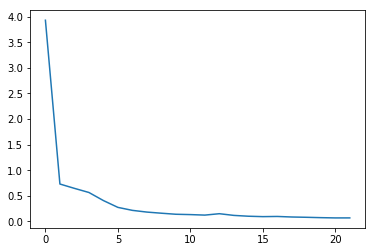

In [22]:
plt.plot(all_training_losses)